

This script is meant to apply transfer learning to a pretrained model with your own data. The script gives several different options, including performing a hyperparameter sweep with Optuna to get a lead on the ideal hyperparameters, as well as the option for tracking the results with WandB (you need to make an account and get an API key first). It also includes some data and model analysis. Here, we will be using ResNet-18, which was previously trained on ImageNet's image database. This code works both on Colab or your preferred editor, except for the first cell where you should install the dependencies beforehand.


In [ ]:
#In google colab you have to do the pip install in a cell beforehand. Many python packages are already preinstalled, besides these two.
!pip install optuna wandb

Here are the dependencies for training the Image Classification model.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from IPython.display import clear_output
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import time
import shutil

This block of code includes pre-configured inputs for easy use. After this section, minimal modifications are required, except for the data loading method. To utilize the post-training model, simply set HYPERPARAMETER_SEARCH to False. Note that this setting is intended for single-model usage, where you already have a promising model configuration.

In [ ]:
##Possible factors to change in the code##
TRACK_DATA= False #Do you want to track the runs by uploading run data to WandB?
DATA_ANALYSIS = True #for checking the data, such as class len, total len, class imbalance, and image samples
HYPERPARAMETER_SEARCH = False #Do you want to activate Optuna to do a hyperparameter sweep?
num_labels= 70 #Even though it is the same variable from the data analysis, I seperated it so the user doesn't have to run data anlysis each time
WandB_project_name = "Dog Classification Project"
max_optuna_epochs = 3
n_trials = 2
"""The number of trials for optuna to run. If you have a good gpu it is worth doing high numbers here
  It uses the previous runs to improve later runs. For example, if the later run is underperforming the median of the previous runs, it drops it early"""

# If HYPERPARAMETER_SEARCH is set to True, Optuna handles these variables automatically
lr = 0.01
num_epochs = 3
batch_size = 32


img_moved = 5 #Set here the number of images you want the test and the val each to recieve. It takes that many images*2 from the train data
RANDOM = False
"""If you want to randomize the images transferred. Not random is good
for comparing different runs, but random is good to get different test and validation sets,
making the data more generalizable. Note that the large dataset already came with 10 images in each test and val folder."""
SAVE_MODEL = True #Do you want to save the weights and biases of the model? HYPERPARAMETER_SEARCH must be False

Connect Google Drive to Colabs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data from Google Drive to Coogle Colabs

In [ ]:
!unzip '/content/drive/MyDrive/Data.zip' -d '/content/data'

clear_output() #it lists every file uploaded, so I clear this list as soon as it is done

#Loading it from a zip file from drive is faster than already having the files unzipped in google drive

The data is usually divided into the parent folder, followed by three subfolders for the test, train, and validation sets. Each subfolder then contains a folder for each class.

In [ ]:
if RANDOM:
    import random

# define your directories to your data. This assumes you have a main folder with the TVT subfolder format, followed by individual class folders in each of them
root_dir = "/content/data/DC2"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
valid_dir = os.path.join(root_dir, "valid")

# get the list of classes (uses the train data in this case, but test and valid should always be the same)
classes = os.listdir(train_dir)

# for each class, move 5 images from train to test and valid
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    valid_class_dir = os.path.join(valid_dir, class_name)

    # create the class directory in test and valid if it does not exist
    os.makedirs(test_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)

    # get a list of images in the train directory for this class
    images = sorted(os.listdir(train_class_dir))
    if RANDOM:
        random.shuffle(images) #If you want to randomize the images transferred
    # select the first 10 images to move
    images_to_move = images[:img_moved*2]

    # move 5 images to test
    for i, image in enumerate(images_to_move[:img_moved]):
        new_name = f"{class_name}_test_{i}.jpg"  # change the extension if needed
        shutil.move(os.path.join(train_class_dir, image), os.path.join(test_class_dir, new_name))

    # move 5 images to valid
    for i, image in enumerate(images_to_move[img_moved:]):
        new_name = f"{class_name}_valid_{i}.jpg"  # change the extension if needed
        shutil.move(os.path.join(train_class_dir, image), os.path.join(valid_class_dir, new_name))


The code block below standardizes all images for the model to process. Please verify the size and normalization requirements of the transfer model, as most models use the following dimensions and normalization. Additionally, I've applied a random horizontal flip to the training images for enhanced data augmentation.
The datasets.ImageFolder function loads the data (in the specified format) and applies the transformations. Utilize the dataloader to load the data in smaller batches, which reduces memory usage and is essential for data parallelization or training with multiple GPUs (not implemented in this code).

In [ ]:
#Use the updated v2.Compose for the transformation, the newer version of transforms.compose
transforms_train = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    v2.CenterCrop((224, 224)),# data augmentation
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

#The transformation for the test and valid sets. Must be the same dimension as above, and you shouldn't do data augmentation here
transforms_test = v2.Compose([
    v2.Resize((224, 224), antialias=True),   #must same as here
    v2.CenterCrop((224, 224)),
    v2.ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transforms_train)
val_dataset = datasets.ImageFolder(valid_dir, transforms_test)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

The following cell performs data analysis to ensure correctness and provides insights into data balance and class distribution. This is crucial for neural networks, as the final layer's output features must match the number of classes. This step can be skipped for convenience by setting DATA_ANALYSIS to 'False' in the options cell, avoiding redundant analysis on subsequent runs.

In [ ]:
if DATA_ANALYSIS:
    #Using matplotlib, define where to get the chart data and how you want to format the chart
    def plot_histogram(directory, title):
        classes = os.listdir(directory)
        counts = [len(os.listdir(os.path.join(directory, cls))) for cls in classes]
        df = pd.DataFrame(list(zip(classes, counts)), columns=['Class', 'Count'])
        df = df.sort_values('Class')
        plt.figure(figsize=(30,10))
        plt.bar(df['Class'], df['Count'])
        plt.title(title)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.xticks(rotation='vertical')
        plt.show()

    # Now you can call the function for each directory
    plot_histogram(train_dir, 'Number of images per class in training set')
    plot_histogram(test_dir, 'Number of images per class in test set')
    plot_histogram(valid_dir, 'Number of images per class in validation set')

    counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}

    # Find the class with the minimum number of images
    min_class = min(counts, key=counts.get)
    min_count = counts[min_class]

    # Find the class with the maximum number of images
    max_class = max(counts, key=counts.get)
    max_count = counts[max_class]

    print(f'The class with the lowest number of images is "{min_class}" with {min_count} images.')
    print(f'The class with the highest number of images is "{max_class}" with {max_count} images.')



    def gini_index(arr):
        #Another metric for checking the class balance in the data.
        #Gini coefficient is used for measuring income equality but works here too
        arr = np.array(arr, dtype=np.float32)
        arr = arr / np.sum(arr)
        arr = np.sort(arr)
        index = np.arange(1, arr.shape[0] + 1)
        n = arr.shape[0]
        return ((np.sum((2 * index - n  - 1) * arr)) / n)

    counts_values = list(counts.values())
    gini = gini_index(counts_values)
    print(f"Gini Index: {gini}")

    #print out a bunch of info based off previous calculations
    print('Train dataset size:', len(train_dataset))
    print('Total classes:', len(train_dataset.classes))  # Use train_dataset as an example
    print('Unique classes in train dataset:', len(set(train_dataset.targets)))

    print('Validation dataset size:', len(val_dataset))
    print('Total classes:', len(val_dataset.classes))  # Use val_dataset as an example
    print('Unique classes in validation dataset:', len(set(train_dataset.targets)))

    print('Test dataset size:', len(test_dataset))
    print('Total classes:', len(test_dataset.classes))  # Use test_dataset as an example
    print('Unique classes in test dataset:', len(set(test_dataset.targets)))

    class_names = train_dataset.classes
    print('Class names:', class_names)

    #Use matplotlib again to see a few samples of the transformed images
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 60
    plt.rcParams.update({'font.size': 20})
    def imshow(input, title):
        # torch.Tensor => numpy
        input = input.numpy().transpose((1, 2, 0))
        # undo image normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        input = std * input + mean
        input = np.clip(input, 0, 1)
        # display images
        plt.imshow(input)
        plt.title(title)
        plt.show()
    # load a batch of train image
    iterator = iter(train_loader)
    # visualize a batch of train image
    inputs, classes = next(iterator)
    out = torchvision.utils.make_grid(inputs[:4])
    imshow(out, title=[class_names[x] for x in classes[:4]])

The code then establishes device agnosticism, enabling seamless execution on either a CPU or an NVIDIA GPU. Note that using an NVIDIA GPU is highly recommended, as it significantly reduces training time.

In [ ]:
#Makes the code device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
use_cuda = torch.cuda.is_available()

if torch.cuda.is_available():
  print("CUDA is available!")
else:
  print("CUDA is not available.")

CUDA is available!


This section defines the functions used for calculations during model training, as well as the model architecture itself.

In [ ]:
#Define the computations you want for your model

def compute_f1_score(model, dataloader):
    #set the model to eval for better training
    model.eval()
    #Appends the labels into a list for later calculation
    true_labels = []
    pred_labels = []

    for idx, (inputs, labels) in enumerate(dataloader):#For loop to iterate over data. Use the dataloader to calculate in batches
        inputs = inputs.to(device) #The model must always be in the same device as the data
        labels = labels.to(device)

        with torch.no_grad(): #reduce unecessary gradient calculations
            logits = model(inputs)

        predictions = torch.argmax(logits, dim=1) #get the predicted class labels by applying the argmax function
        true_labels.extend(labels.detach().cpu().numpy()) #detatch labels and prediction from the computation graph and turn them into numpy arrays
        pred_labels.extend(predictions.detach().cpu().numpy())
#Choose 'macro' for the parameter as it is the best for such a high number of classes. It weights the classes equally regardless of how many datapoints each one has
    f1 = f1_score(true_labels, pred_labels, average='macro')
    return f1


def compute_accuracy(model, dataloader):
    model.eval()
    correct = 0.0 #Keep track of the number of correct predictions and total number of examples processesd
    total_examples = 0 #same as above. both of these start keeping track at 0
    for idx, (inputs, labels) in enumerate(dataloader):
        #the next 4 lines are needed for any calculation
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(inputs)
        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions
        correct += torch.sum(compare) #compare predicted with true labels as a tensor
        total_examples += len(compare) #sum up the number of correct predictions and total examples
    accuracy = correct / total_examples #calculate accuracy
    return accuracy.item()  # return a Python scalar (single number)

def train_model(model, train_loader, val_loader, test_loader, lr, num_epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.0) #Will be leaving the optimizer at 0 momentum, but can be changed
                                                                           #From experience SGD is stronger for image classification. Adam is more often used for LLM tuning
                                                                           #Optimizers are used to update the model parameters after each apoch
    loss_list = []
    train_acc_list, val_acc_list = [], []
    val_f1_list = []
    overfitting_list = []

    start_time = time.time()
    for epoch in range(num_epochs):

        model = model.train() #set the model to training mode instead of eval
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs) #Passes inputs through the model to get logits.

            loss = F.cross_entropy(logits, labels) #Computes the loss using cross-entropy.

            optimizer.zero_grad()
            loss.backward() #Backpropagate the loss
            optimizer.step() #Updates the model parameters with optimizer.step().

            if not batch_idx % 250: #Logs the training loss every 250 batches.
                ### LOGGING
                print(
                    f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                    f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                    f" | Train Loss: {loss:.2f}"
                )
            loss_list.append(loss.item())

        train_f1 = compute_f1_score(model, train_loader)
        val_f1 = compute_f1_score(model, val_loader)
        print(f"Train F1 {train_f1*100:.2f}% | Val F1 {val_f1*100:.2f}%")

        #Running the calculations
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
        overfitting = train_acc-val_acc
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)
        overfitting_list.append(overfitting)
        if TRACK_DATA:
          wandb.log({"acc": val_acc, "overfitting": overfitting, "loss": loss, "F1 Macro": val_f1 })

    test_acc = compute_accuracy(model, test_loader)
    print(f"Test Acc {test_acc*100:.2f}%")
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    if TRACK_DATA:
      wandb.finish() #Log WandB after each run, regardless of Optuna being on or off
    return max(val_f1_list)



There are models that have improved accuracy over ResNet18, but I am using this due to its balance of speed and performance. I originally had the model as one of the changeable options in the options cell, but some models use different layers, so changing the model requires more than just loading the name.

In [ ]:
model_name= "resnet18" #variable used in WandB init code as well

def load_model(model_name, num_labels, device):
    # Load the pre-trained model
    mod = getattr(models, model_name)
    model = mod(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    #print(model)#  Print the model to see the layers that need to be changed.

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Modify the last layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_labels)

    # Move the model to the device
    model = model.to(device)

    return model


The next block initializes the functions for training. The conditionals are based on the user's settings, where True or False values determine the execution flow. If TRACK_DATA is set to True, the terminal will prompt the user to enter a Weights & Biases (WandB) API key. To provide the API key, you must have a WandB account set up. You can find the API key in the quickstart guide by clicking the question mark icon next to your name in the top right corner.

In [ ]:
if HYPERPARAMETER_SEARCH: #Hyperparameter searches can be time/resource consuming. Makes sure you really don't want to track the runs
    if not TRACK_DATA:
        response = input("Do you want to proceed with the hyperparameter sweep without tracking the performance data? If you choose ‘yes’, the sweep will run but no performance data will be recorded for analysis. (y/n)")
        if response.lower() == 'y':
            print("Data tracking disabled.")
        else:
            TRACK_DATA = True
            print("Data tracking with WandB enabled.")


if TRACK_DATA:
  import wandb
  def init_wandb(project_name, lr, batch_size, model_name, num_epochs):
    wandb.init(
        project=project_name, #Name of the project as inputed in the options cell
        config={   #which variables do you want to log in each run?
            "learning_rate": lr,
            "batch_size": batch_size,
            "model_architecture": model_name,
            "epochs": num_epochs})

  wandb.login()

if not HYPERPARAMETER_SEARCH:
  model = load_model(model_name, num_labels, device)
  if TRACK_DATA:
      init_wandb(WandB_project_name, lr, batch_size, model_name, num_epochs)

  max_val_f1 = train_model(model, train_loader, val_loader, test_loader, lr, num_epochs)
  if TRACK_DATA:
    wandb.finish()

if HYPERPARAMETER_SEARCH:
  import optuna
  def objective(trial):
      # Suggest values for the hyperparameters
      lr = trial.suggest_float("lr", 1e-2, 1e-1, log=True)
      num_epochs = trial.suggest_int("num_epochs", 2, max_optuna_epochs)
      batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

      model = load_model(model_name, num_labels, device)

      if TRACK_DATA:
        init_wandb(WandB_project_name, lr, batch_size, model_name, num_epochs)

      # Call the train_model function
      max_val_f1 = train_model(model, train_loader, val_loader, test_loader, lr, num_epochs)
      return max_val_f1

  study = optuna.create_study(
      direction="maximize", #this tells optuna that the variable we want it to study, we want it to be as high as possible (such asf1 score, instead of loss which would be minimize)
      study_name="Study", #Anything here really, I am using WandB to track the information so the name in Optuna doesn't matter
      pruner=optuna.pruners.MedianPruner(),
  )
  study.optimize(objective, n_trials=n_trials)


When you are ready to save, ensure that HYPERPARAMETER_SEARCH is set to False and SAVE_MODEL is set to True. For efficiency purposes, we are only saving the model's learned parameters, specifically the model's state dictionary.

In [ ]:
if not HYPERPARAMETER_SEARCH:
  if SAVE_MODEL:
    from pathlib import Path
    # 1. Create models directory
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # 2. Create model save path
    MODEL_NAME = "Trained_parameters.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # 3. Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
              f=MODEL_SAVE_PATH)

Saving model to: models/DogID2.pth


This calculates the probability that the correct dog breed is among the model's top 3 predicted responses, allowing the user to choose from the three most probable breeds.

In [ ]:
if not HYPERPARAMETER_SEARCH:
    def compute_top3_accuracy(model, dataloader):
        model.eval()
        correct = 0.0
        total_examples = 0
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                logits = model(inputs)
            top3_preds = torch.topk(logits, 3, dim=1)[1]
            correct += torch.sum(top3_preds == labels.view(-1, 1).expand_as(top3_preds)).item()
            total_examples += len(labels)
        top3_accuracy = correct / total_examples
        return top3_accuracy
    test_top3_acc = compute_top3_accuracy(model, test_loader)
    print(f"Test Top-3 Acc: {test_top3_acc*100:.2f}%")


Test Top-3 Acc: 98.57%


The following calculates the accuracy PER CLASS and graphs the results.

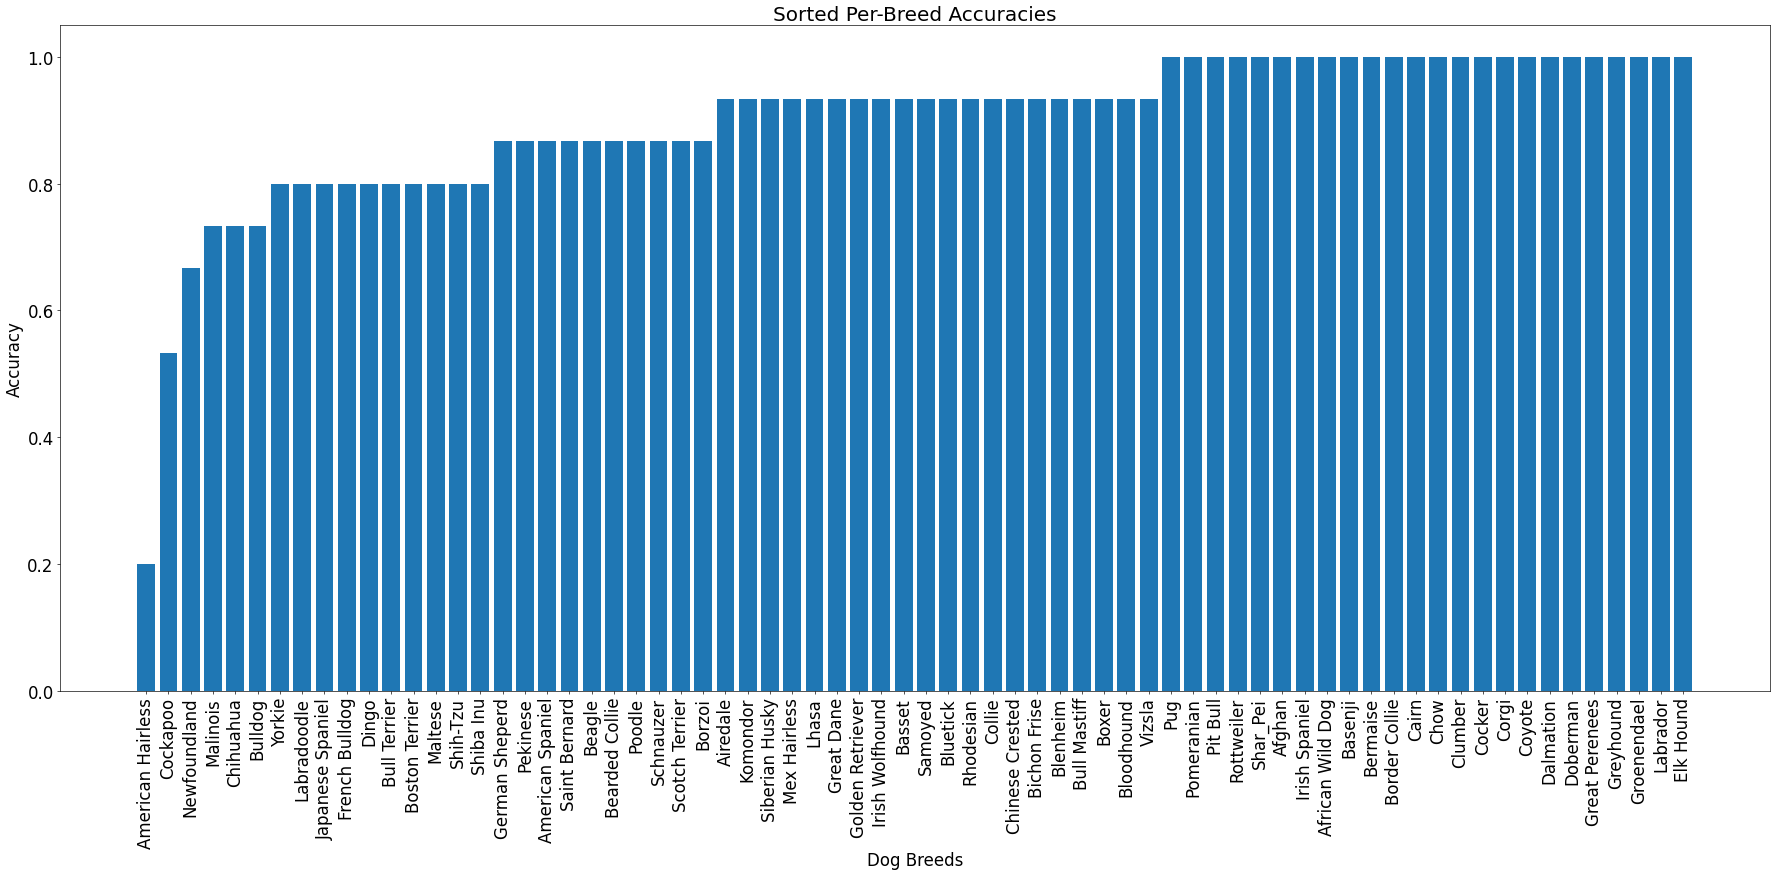

Test Acc for class American Hairless: 20.00%
Test Acc for class Cockapoo: 53.33%
Test Acc for class Newfoundland: 66.67%
Test Acc for class Malinois: 73.33%
Test Acc for class Chihuahua: 73.33%
Test Acc for class Bulldog: 73.33%
Test Acc for class Yorkie: 80.00%
Test Acc for class Labradoodle: 80.00%
Test Acc for class Japanese Spaniel: 80.00%
Test Acc for class French Bulldog: 80.00%
Test Acc for class Dingo: 80.00%
Test Acc for class Bull Terrier: 80.00%
Test Acc for class Boston Terrier: 80.00%
Test Acc for class Maltese: 80.00%
Test Acc for class Shih-Tzu: 80.00%
Test Acc for class Shiba Inu: 80.00%
Test Acc for class German Sheperd: 86.67%
Test Acc for class Pekinese: 86.67%
Test Acc for class American Spaniel: 86.67%
Test Acc for class Saint Bernard: 86.67%
Test Acc for class Beagle: 86.67%
Test Acc for class Bearded Collie: 86.67%
Test Acc for class Poodle: 86.67%
Test Acc for class Schnauzer: 86.67%
Test Acc for class Scotch Terrier: 86.67%
Test Acc for class Borzoi: 86.67%
Tes

In [ ]:
if not HYPERPARAMETER_SEARCH:
  def compute_per_class_accuracy(model, dataloader, num_classes):
      model.eval()
      correct_per_class = [0.0] * num_classes
      total_per_class = [0.0] * num_classes
      for idx, (inputs, labels) in enumerate(dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          with torch.no_grad():
              logits = model(inputs)
          predictions = torch.argmax(logits, dim=1)
          for i in range(num_classes):
              correct_per_class[i] += torch.sum((predictions == i) & (labels == i)).item()
              total_per_class[i] += torch.sum(labels == i).item()
      accuracy_per_class = [correct / total if total > 0 else 0 for correct, total in zip(correct_per_class, total_per_class)]
      return accuracy_per_class  # return a list of Python scalars
  class_names = train_dataset.classes

  # Compute per-class accuracy for the test set after training
  test_per_class_acc = compute_per_class_accuracy(model, test_loader, num_classes=len(train_dataset.classes))

  sorted_indices = np.argsort(test_per_class_acc)
  sorted_accuracies = np.array(test_per_class_acc)[sorted_indices]
  sorted_class_names = np.array(class_names)[sorted_indices]

  # Create a sorted bar plot for accuracies
  plt.figure(figsize=(30, 15))  # Adjust as needed
  plt.bar(sorted_class_names, sorted_accuracies)
  plt.xlabel('Dog Breeds')
  plt.ylabel('Accuracy')
  plt.title('Sorted Per-Breed Accuracies')
  plt.xticks(rotation=90)  # Rotate x-axis labels for readability if dog breeds are long
  plt.tight_layout()  # Ensure that labels fit into the figure area
  plt.show()
  # Get the class names


  for i, acc in enumerate(sorted_accuracies):
      print(f"Test Acc for class {sorted_class_names[i]}: {acc*100:.2f}%")

The following calculates the f1 score PER CLASS and graphs the results.

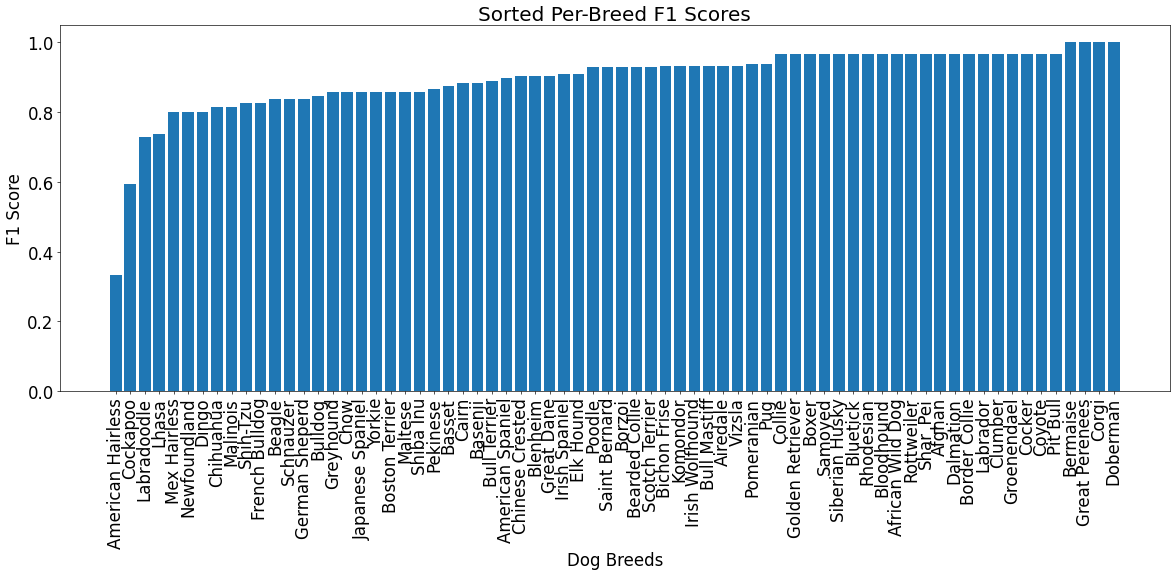

F1 Score for American Hairless: 0.33
F1 Score for Cockapoo: 0.59
F1 Score for Labradoodle: 0.73
F1 Score for Lhasa: 0.74
F1 Score for Mex Hairless: 0.80
F1 Score for Newfoundland: 0.80
F1 Score for Dingo: 0.80
F1 Score for Chihuahua: 0.81
F1 Score for Malinois: 0.81
F1 Score for Shih-Tzu: 0.83
F1 Score for French Bulldog: 0.83
F1 Score for Beagle: 0.84
F1 Score for Schnauzer: 0.84
F1 Score for German Sheperd: 0.84
F1 Score for Bulldog: 0.85
F1 Score for Greyhound: 0.86
F1 Score for Chow: 0.86
F1 Score for Japanese Spaniel: 0.86
F1 Score for Yorkie: 0.86
F1 Score for Boston Terrier: 0.86
F1 Score for Maltese: 0.86
F1 Score for Shiba Inu: 0.86
F1 Score for Pekinese: 0.87
F1 Score for Basset: 0.87
F1 Score for Cairn: 0.88
F1 Score for Basenji: 0.88
F1 Score for Bull Terrier: 0.89
F1 Score for American Spaniel: 0.90
F1 Score for Chinese Crested: 0.90
F1 Score for Blenheim: 0.90
F1 Score for Great Dane: 0.90
F1 Score for Irish Spaniel: 0.91
F1 Score for Elk Hound: 0.91
F1 Score for Poodle: 

In [ ]:
if not HYPERPARAMETER_SEARCH:
  def compute_f1_score_per_class(model, dataloader, num_classes):
      model.eval()
      true_labels = []
      predicted_labels = []
      for idx, (inputs, labels) in enumerate(dataloader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          with torch.no_grad():
              logits = model(inputs)
          predictions = torch.argmax(logits, dim=1)
          true_labels.extend(labels.detach().cpu().numpy())
          predicted_labels.extend(predictions.detach().cpu().numpy())
      f1_scores = f1_score(true_labels, predicted_labels, average=None)  # 'None' for scores for each class
      return f1_scores  # return a list of Python scalars
  # Compute F1 score for each class in the test set after training
  # Compute F1 score for each class in the test set after training
  # Compute F1 score for each class in the test set after training
  test_f1_scores = compute_f1_score_per_class(model, test_loader, num_classes=len(train_dataset.classes))
  class_names = train_dataset.classes  # Assuming class_names are your dog breeds

  # Sort the scores and corresponding class names
  sorted_indices = np.argsort(test_f1_scores)
  sorted_f1_scores = test_f1_scores[sorted_indices]
  sorted_class_names = np.array(class_names)[sorted_indices]
  # Create a sorted bar plot for F1 scores
  plt.figure(figsize=(20, 10))  # Adjust as needed
  plt.bar(sorted_class_names, sorted_f1_scores)
  plt.xlabel('Dog Breeds')
  plt.ylabel('F1 Score')
  plt.title('Sorted Per-Breed F1 Scores')
  plt.xticks(rotation=90)  # Rotate x-axis labels for readability if dog breeds are long
  plt.tight_layout()  # Ensure that labels fit into the figure area
  plt.show()

  class_names = train_dataset.classes  # Assuming class_names are your dog breeds
  for i, f1 in enumerate(sorted_f1_scores):
      print(f"F1 Score for {sorted_class_names[i]}: {f1:.2f}")
